In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *
from utils.feature_engineering import *
from utils.nn import *
from utils.plot_nn_training import *

In [2]:
print(tf.__version__)

# we need to set up gpus for tensorflow-gpu and cudnn
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
warnings.filterwarnings("ignore")

# Download, read in, preprocess data

In [4]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


In [5]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

One of the first things we need to take care of is the precipitation column. There are some extremely high values throughout the dataset that we need to drop.

In [6]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]
regions_precip

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3003,2017-12-07,1.0,0.0,0.0,0.0,5.0,2.0
3007,2017-12-07,1.4,6.2,0.0,5.5,12.1,4.3
3009,2017-12-07,1.5,8.0,6.2,5.4,10.6,2.7
3010,2017-12-07,0.1,9.2,12.2,9.0,8.0,2.5
3011,2017-12-07,0.1,9.8,14.2,11.6,8.6,3.0
...,...,...,...,...,...,...,...
3031,2021-01-12,0.0,5.0,10.0,15.0,0.0,0.0
3032,2021-01-12,0.0,0.0,3.0,2.0,0.0,0.0
3034,2021-01-12,0.0,4.0,12.0,10.0,0.0,0.0


There is a set of anomalously high precipitation values in this dataset that we need to be mindful of.

In [7]:
precip_outliers = np.where(regions_precip > 100)[0]
regions_precip.iloc[precip_outliers].head(25)

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3006,2020-04-30,6280.500,0.0,0.1,0.3,0.900,1.7
3007,2020-04-30,6280.500,0.0,0.0,0.2,1.300,1.5
3009,2020-04-30,6280.900,0.0,0.0,0.3,1.200,1.6
3010,2020-04-30,6280.500,0.0,0.0,0.2,1.100,2.2
3011,2020-04-30,6280.500,0.0,0.0,0.0,0.700,1.0
3012,2020-04-30,6280.500,0.0,0.0,0.0,0.300,0.7
3013,2020-04-30,6280.858,0.0,0.0,0.1,0.600,1.1
3014,2020-04-30,6280.500,0.0,0.0,0.0,0.200,0.1
3015,2020-04-30,6280.500,0.0,0.0,0.0,0.700,1.1


In [8]:
drop_idx = regions.index[precip_outliers]
regions = regions.drop(drop_idx)
regions

,,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-12-07,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3009,2017-12-07,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3011,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
regions.loc[:, precip_cols].max()

precip_0    95.6
precip_1    95.6
precip_2    95.6
precip_3    95.6
precip_4    95.6
precip_5    95.6
dtype: float64

These seem like more reasonable values. We need to do the same thing for the labels, though.

In [10]:
labels = labels.drop(drop_idx)

In [11]:
print('Shape of input data:  {}'.format(regions.shape))
print('Shape of labels    :  {}'.format(labels.shape))

Shape of input data:  (12519, 6516)
Shape of labels    :  (12519, 69)


In [12]:
# encode cause and aspect columns in labels
labels = encode_causes(labels)
labels = encode_aspects(labels)

In a previous Notebook analysis on the importance of different features, we say that different meteorological variables from RegObs are often more important than other fields included in the data. And what's more, combining variables to create custom features is even *more* important. We can create those features again below.

In [13]:
# drop wind speed columns
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
#regions.drop(wind_dir_cols, axis=1, inplace=True)

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

In [14]:
dont_include_list = ['acc', 'dir', 'fl_start', 'regobs', 'start']
to_include = [col for col in regions.columns]

for drop_col in dont_include_list:
    to_include = [col for col in to_include if drop_col not in col]

#to_include

In [15]:
train = regions.loc[:, to_include]
train

,,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,temp_freeze_lev_5,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000,15.5,9.0,9.0,0.0,9.0,9.0,33.5,1.0,-8.0
3007,2017-12-07,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,237.510,12.0,9.0,5.5,9.0,9.0,12.0,26.5,7.6,-5.9
3009,2017-12-07,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,267.920,15.5,5.5,9.0,9.0,9.0,9.0,30.0,15.7,-6.5
3010,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,326.270,15.5,5.5,12.0,12.0,9.0,9.0,33.0,21.5,-6.2
3011,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,210.565,12.0,5.5,5.5,9.0,9.0,9.0,23.0,24.1,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.000,9.0,5.5,5.5,15.5,0.0,0.0,20.0,15.0,-5.0
3032,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.000,12.0,5.5,9.0,12.0,0.0,0.0,26.5,3.0,-9.0
3034,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.000,9.0,5.5,9.0,12.0,5.5,5.5,23.5,16.0,-7.0


## Scale data

In [16]:
scaled_X = scale_input_data(train.values)
train = pd.DataFrame(scaled_X, columns=train.columns, index=train.index)
train

,,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,temp_freeze_lev_5,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,...,0.000000,0.516667,0.300000,0.300000,0.000000,0.300000,0.300000,0.403614,0.006545,0.371942
3007,2017-12-07,0.666667,0.333333,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.095004,0.400000,0.300000,0.183333,0.300000,0.300000,0.400000,0.319277,0.049744,0.418220
3009,2017-12-07,0.666667,0.333333,0.333333,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.107168,0.516667,0.183333,0.300000,0.300000,0.300000,0.300000,0.361446,0.102760,0.404998
3010,2017-12-07,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.130508,0.516667,0.183333,0.400000,0.400000,0.300000,0.300000,0.397590,0.140722,0.411609
3011,2017-12-07,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.084226,0.400000,0.183333,0.183333,0.300000,0.300000,0.300000,0.277108,0.157740,0.504165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.000000,0.300000,0.183333,0.183333,0.516667,0.000000,0.000000,0.240964,0.098178,0.438054
3032,2021-01-12,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.000000,0.400000,0.183333,0.300000,0.400000,0.000000,0.000000,0.319277,0.019636,0.349905
3034,2021-01-12,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.000000,0.300000,0.183333,0.300000,0.400000,0.183333,0.183333,0.283133,0.104724,0.393979


In [17]:
print(np.any(np.isnan(train)))

False


In [18]:
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_problem_1']]
train_labels

,,CLASS_problem_1
region,date,
3003,2017-12-07,1
3007,2017-12-07,5
3009,2017-12-07,5
3010,2017-12-07,1
3011,2017-12-07,1
...,...,...
3031,2021-01-12,5
3032,2021-01-12,5
3034,2021-01-12,5


Here, we want to combine and drop some problems. Problem 0 means that it wasn't given, and problem 3 is new-loose which is hard to predict. We can also combine problems 2 (glide) and 7 (wet-slab) to just be 1 problem (wet-slab).

In [19]:
drop_prob0_idx = train_labels.index[np.where(np.logical_or(train_labels == 0, train_labels == 3))[0]]
drop_prob0_idx

MultiIndex([(3016, '2017-12-15'),
            (3017, '2017-12-16'),
            (3029, '2018-01-19'),
            (3014, '2018-02-02'),
            (3017, '2018-02-02'),
            (3014, '2018-02-03'),
            (3014, '2018-02-04'),
            (3006, '2018-04-01'),
            (3014, '2018-05-17'),
            (3014, '2018-05-18'),
            (3014, '2018-05-19'),
            (3014, '2018-05-20'),
            (3031, '2018-12-23'),
            (3024, '2019-02-27'),
            (3037, '2019-05-05'),
            (3037, '2019-05-17'),
            (3037, '2019-05-18'),
            (3037, '2019-05-19'),
            (3037, '2019-05-20'),
            (3037, '2019-05-21'),
            (3037, '2019-05-22'),
            (3037, '2019-05-23'),
            (3028, '2019-05-24'),
            (3037, '2019-05-24'),
            (3028, '2019-05-25'),
            (3029, '2019-05-25'),
            (3037, '2019-05-25'),
            (3022, '2020-05-14'),
            (3023, '2020-05-14'),
            (3

In [20]:
train_labels.drop(drop_prob0_idx, inplace=True)
train.drop(drop_prob0_idx, inplace=True)

In [21]:
print(train_labels.shape)
print(train.shape)

(12481, 1)
(12481, 1335)


In [22]:
train_labels.replace(2, 7, inplace=True)

In [23]:
np.unique(train_labels)

array([1, 4, 5, 6, 7])

Now we should reassign labels to go from 0 - number of unique values.

In [24]:
train_labels.replace(1, 0, inplace=True)
train_labels.replace(4, 1, inplace=True)
train_labels.replace(5, 2, inplace=True)
train_labels.replace(6, 3, inplace=True)
train_labels.replace(7, 4, inplace=True)

In [25]:
np.unique(train_labels)

array([0, 1, 2, 3, 4])

So now the avalanche problems are encoded like so:
- 0: drift-slab
- 1: new-slab
- 2: pwl-slab
- 3: wet-loose
- 4: glide and wet-slab

In [26]:
class_occurrences = (train_labels.value_counts() / len(train_labels) * 100).sort_index()
round(class_occurrences, 2)

CLASS_problem_1
0                  49.95
1                  13.12
2                  13.39
3                  16.87
4                   6.67
dtype: float64

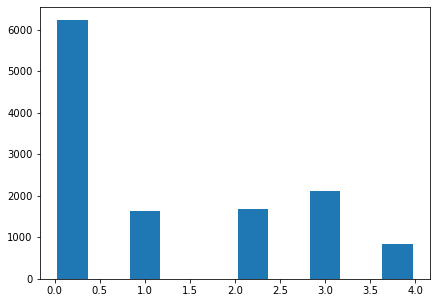

In [27]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(train_labels, rwidth=0.85)
plt.show()

So we see that there is a heavy imbalance in the class weights that we are trying to predict (look at avalanche problems 0, 2, and 3). This is not ideal for our case.

Scikit-learn makes this easy to compute the class weights for imbalanced classification tasks.

In [29]:
flat_values = [value[0] for value in train_labels.values]
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(flat_values),
                                            flat_values)
print(weights)

[0.40041707 1.52393162 1.49383603 1.18584323 2.99663866]


In [30]:
weights = {
    0: 0.4,
    1: 1.52,
    2: 1.49,
    3: 1.19,
    4: 3.0,
}

# Split data

In [31]:
train_idx = [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 
             3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
val_idx =   [3011, 3016, 3035]
test_idx =  [3006, 3015, 3034]

X_train = [train.loc[idx].values for idx in train_idx]
y_train = [train_labels.loc[idx].values for idx in train_idx]

X_val = [train.loc[idx].values for idx in val_idx]
y_val = [train_labels.loc[idx].values for idx in val_idx]

X_test = [train.loc[idx].values for idx in test_idx]
y_test = [train_labels.loc[idx].values for idx in test_idx]

In [32]:
print(len(train_idx), len(X_train), len(y_train))
print(len(val_idx), len(X_val), len(y_val))
print(len(test_idx), len(X_test), len(y_test))

16 16 16
3 3 3
3 3 3


In [33]:
sequence_length = 14 # this is an arbitrary choice, a hyperparameter
X_train_pad = [pad_sequence(arr, sequence_length) for arr in X_train]
y_train_pad = [pad_sequence(arr, sequence_length) for arr in y_train]

X_val_pad = [pad_sequence(arr, sequence_length) for arr in X_val]
y_val_pad = [pad_sequence(arr, sequence_length) for arr in y_val]

X_test_pad = [pad_sequence(arr, sequence_length) for arr in X_test]
y_test_pad = [pad_sequence(arr, sequence_length) for arr in y_test]

In [34]:
for (arr, label) in zip(X_train_pad, y_train_pad):
    print(arr.shape, label.shape)

(574, 1335) (574, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)
(322, 1335) (322, 1)
(574, 1335) (574, 1)
(574, 1335) (574, 1)


### Creating a windowed dataset
- https://curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/
- https://stackoverflow.com/questions/45435049/lstm-understand-timesteps-samples-and-features-and-especially-the-use-in-resha
- https://stackoverflow.com/questions/48491737/understanding-keras-lstms-role-of-batch-size-and-statefulness

Instead of jumping by `sequence_length` below, we need to shift by a certain amount every time. So use days 1-7 to predict day 8, days 2-8 to predict day 9, etc.

Then the labels should start by predicting day 8, 9, etc.

In [35]:
# reshape data into (samples, timesteps, features)
X_concat_train = np.concatenate(X_train_pad)
y_concat_train = np.concatenate(y_train_pad)

X_concat_val = np.concatenate(X_val_pad)
y_concat_val = np.concatenate(y_val_pad)

X_concat_test = np.concatenate(X_test_pad)
y_concat_test = np.concatenate(y_test_pad)

print(X_concat_train.shape)
print(y_concat_train.shape)
print(X_concat_val.shape)
print(y_concat_val.shape)
print(X_concat_test.shape)
print(y_concat_test.shape)

(8932, 1335)
(8932, 1)
(1722, 1335)
(1722, 1)
(1302, 1335)
(1302, 1)


In order to use the recall metric, you need to have your vector of binary values one-hot encoded as a 2D matrix. We can do that below.

In [36]:
encoder = OneHotEncoder()
y_concat_train = encoder.fit_transform(y_concat_train).toarray()
y_concat_val = encoder.fit_transform(y_concat_val).toarray()
y_concat_test = encoder.fit_transform(y_concat_test).toarray()

In [37]:
batchX_train, batchY_train = batch_data(X_concat_train, y_concat_train, sequence_length)
batchX_val, batchY_val = batch_data(X_concat_val, y_concat_val, sequence_length)
batchX_test, batchY_test = batch_data(X_concat_test, y_concat_test, sequence_length)

(8918, 14, 1335) (8918, 5)
(1708, 14, 1335) (1708, 5)
(1288, 14, 1335) (1288, 5)


# Training a neural network

### DNN

We can define our neural network below. This is a multiclass classification problem, meaning that we need as many output units in the last layer as there are unique labels in our training set. It also means that we should use a softmax activation in the last layer and some form of categorical crossentropy as the loss function.

In [38]:
input_neurons = 100
output_neurons = len(np.unique(train_labels))
drop = 0.3

# specify hyperparams here
num_epochs = 1000
alpha = 1e-5
batch_size = 256
criterion = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

In [39]:
window_dnn = create_dnn(batchX_train, input_neurons, drop, output_neurons)

window_dnn_history = train_problems(window_dnn, batchX_train, batchY_train, batchX_val, 
                          batchY_val, criterion, optimizer, batch_size, num_epochs, weights)

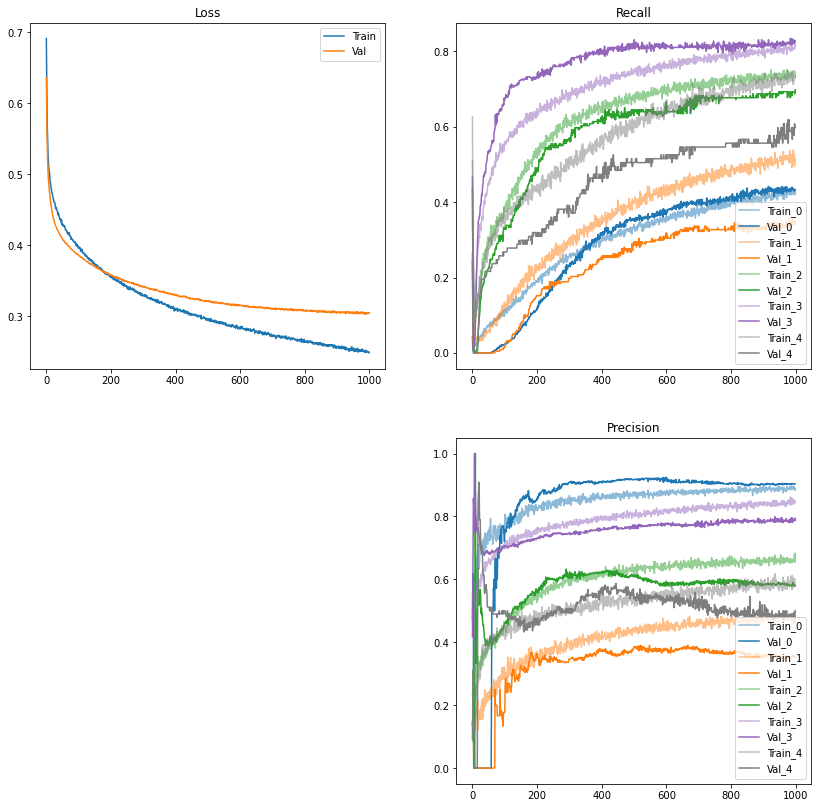

In [40]:
plot_history_problems(window_dnn_history.history)

precision: [0.86456693 0.36026936 0.52313167 0.74566474 0.41610738]
recall:    [0.6039604  0.49308756 0.77777778 0.87162162 0.63917526]
fscore:    [0.7111399  0.41634241 0.62553191 0.80373832 0.50406504]


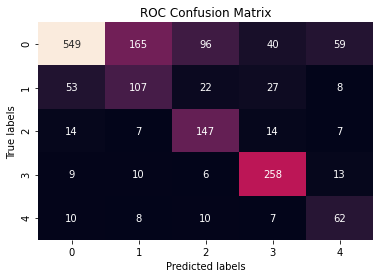

In [41]:
preds = plot_confusion_matrix(window_dnn, batchX_val, np.argmax(batchY_val, axis=1))

In [42]:
window_dnn_reg = create_dnn(batchX_train, input_neurons, drop, output_neurons, True)

window_dnn_reg_history = train_problems(window_dnn_reg, batchX_train, batchY_train, batchX_val, 
                          batchY_val, criterion, optimizer, batch_size, num_epochs, weights)

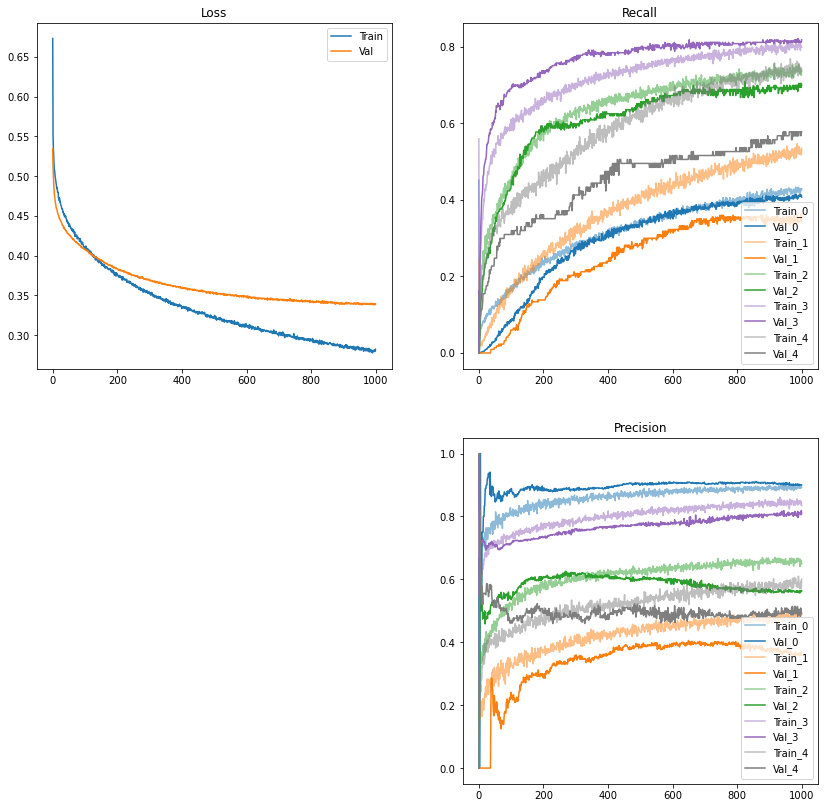

In [43]:
plot_history_problems(window_dnn_reg_history.history)

precision: [0.85804416 0.3390411  0.50859107 0.76204819 0.42138365]
recall:    [0.59845985 0.4562212  0.78306878 0.85472973 0.69072165]
fscore:    [0.7051199  0.38899804 0.61666667 0.80573248 0.5234375 ]


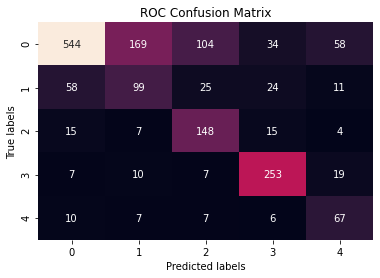

In [44]:
preds = plot_confusion_matrix(window_dnn_reg, batchX_val, np.argmax(batchY_val, axis=1))

We are starting to overfit with the DNN, probably around epoch 800 or so. Recall is increasing across the board, but precision is stagnating.

### LSTM
We can repeat the same steps as above, but this time with a LSTM to see how that affects performance.

In [45]:
# network params
input_neurons = 4
dense_neurons = 10
drop = 0.3

# training params
num_epochs = 1000
alpha = 1e-5
batch_size = 256

In [46]:
window_rnn = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons)

window_rnn_history = train_problems(window_rnn, batchX_train, batchY_train, 
                           batchX_val, batchY_val, criterion, optimizer, 
                           batch_size, num_epochs, weights)

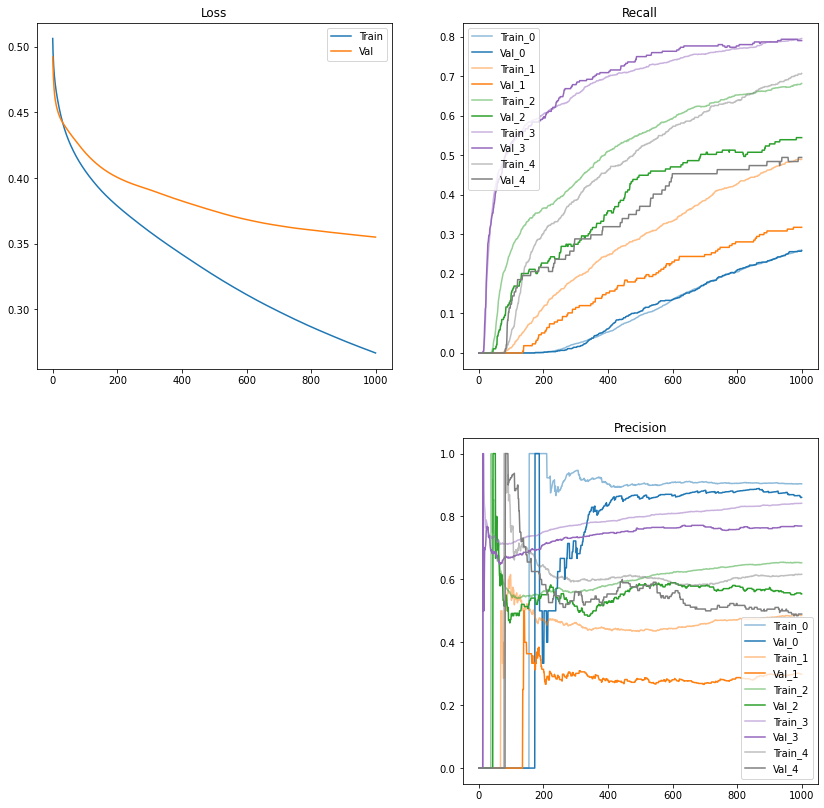

In [47]:
plot_history_problems(window_rnn_history.history)

precision: [0.81086519 0.27821522 0.42087542 0.72543353 0.34759358]
recall:    [0.44334433 0.48847926 0.66137566 0.84797297 0.67010309]
fscore:    [0.57325747 0.35451505 0.51440329 0.78193146 0.45774648]


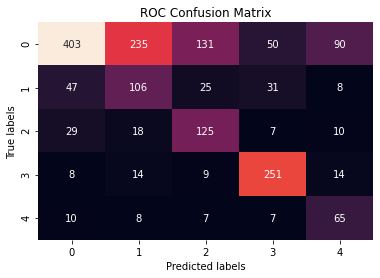

In [48]:
preds = plot_confusion_matrix(window_rnn, batchX_val, np.argmax(batchY_val, axis=1))

This looks like a classic case of [overfitting](https://en.wikipedia.org/wiki/Overfitting). Our validation loss starts increasing and our training loss continues decreasing. We could try to fix this with trying to add regularization to our network, or using a different architecture (maybe with less layers or neurons per layer).

In [49]:
window_rnn_reg = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons, True)

window_rnn_reg_history = train_problems(window_rnn_reg, batchX_train, batchY_train, 
                               batchX_val, batchY_val, criterion, optimizer, 
                               batch_size, num_epochs, weights)

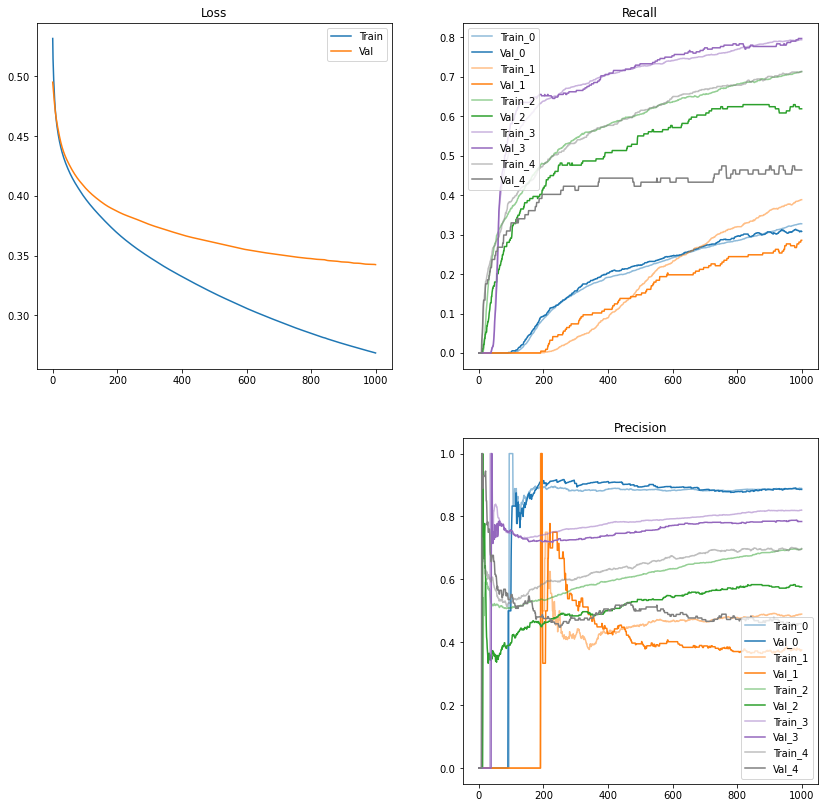

In [50]:
plot_history_problems(window_rnn_reg_history.history)

precision: [0.84816754 0.30259366 0.49647887 0.73313783 0.33128834]
recall:    [0.53465347 0.48387097 0.74603175 0.84459459 0.55670103]
fscore:    [0.65587045 0.37234043 0.5961945  0.78492936 0.41538462]


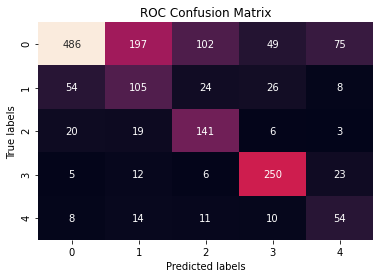

In [51]:
preds = plot_confusion_matrix(window_rnn_reg, batchX_val, np.argmax(batchY_val, axis=1))

# Summary:
The DNN worked better than the RNN did, and across the board it was easiest to predict avalanche problem 4 (in our new encoded system): glide and wet slab avalanches.

# Predicting on the test set

This is relatively easy to set up. Since we have already processed the test set alongside the training and validation sets, it should be ready to go.

The best model so far was the DNN without regularization. We should save this model so that we can load it later (instead of running the whole Notebook again). Note: we only need to save the model once unless we decide to retrain the model later.

In [52]:
# save best model
# https://www.tensorflow.org/tutorials/keras/save_and_load?hl=en
best_dnn = window_dnn_reg
best_rnn = window_rnn_reg

best_dnn.save('models/dnn_problems')
best_rnn.save('models/rnn_problems')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/dnn_problems/assets
INFO:tensorflow:Assets written to: models/rnn_problems/assets


precision: [0.83409091 0.43373494 0.51351351 0.7593985  0.45945946]
recall:    [0.58161648 0.61714286 0.71969697 0.80478088 0.68686869]
fscore:    [0.6853408  0.50943396 0.59936909 0.78143133 0.55060729]


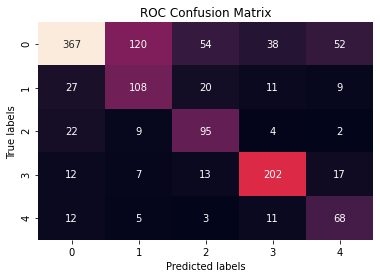

In [54]:
# load saved models
best_dnn = tf.keras.models.load_model('models/dnn_problems')
test_preds = plot_confusion_matrix(best_dnn, batchX_test, np.argmax(batchY_test, axis=1))

precision: [0.78535354 0.31007752 0.5026178  0.71264368 0.2967033 ]
recall:    [0.49286846 0.45714286 0.72727273 0.74103586 0.54545455]
fscore:    [0.60564752 0.36951501 0.59442724 0.7265625  0.38434164]


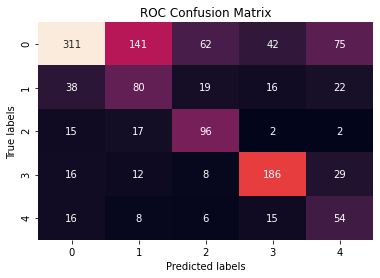

In [55]:
best_rnn = tf.keras.models.load_model('models/rnn_problems')
test_preds = plot_confusion_matrix(best_rnn, batchX_test, np.argmax(batchY_test, axis=1))

In both cases, the models did well for predicting class 3, or wet-loose avalanches. The DNN slightly outperformed the RNN by ~5% recall and precision. Not bad! However, the models did not perform as well in predicting the other avalanche problems at all. Still, it seems like a model could be constructed to predict for wet-loose avalanches.